## Codon Table Class

This class instantiates codon tables with arbitrary, user defined decoding strategies.

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import Bio.Data.CodonTable
from Bio.SubsMat import MatrixInfo as submats
import networkx as nx
from codonUtils import utils
from codonoptimizer import MonteCarlo
from codonTable import codonTable
import bct
import random
import pickle

## Standard Code and Biological Dictionaries

The exact ordering of amino acids and stop codons in order to represent the Standard Code in a pythonic way (e.g. defined by iterating over zipped elements) pulled from NCBI (https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi#SG1).

## Codon Utilities Module

This module was written to wrap a set of generally useful definitions and methods. These include 
- the Standard Codon table
- the set of NTPs and amino acids
- some physicochemical scales (Polar Requirement Scale and Kyte Doolittle Hydropathy)
- codon table block structures
- methods to count amino acid degeneracy
- methods to find adjacency of both codons and residues in a network
- methods to interconvert Codon Table structure to/from representations in block structure form
- method to check the validity of a codon table against a specified block structure

The module is fully documented, as in calling help(codonUtils.utils) will return full documentation of associated attributes and methods.

In [ ]:
help(utils)

## Visualization Object for Codon Tables

This class is designed to take dictionaries representing triplet codon tables and visualizing them in 3D space. For simplicity, the default visualization metric used is the 1982 hydrophobicity scale developed by Kyte and Doolittle (1).

In [ ]:
help(codonTable)

In [ ]:
# Demonstrate CodonTable visualization
%matplotlib inline
test = codonTable()
fig = test.plot3d('Standard Codon Table: Node Color=Hydropathy', )
fig2 = test.plotGraph('Standard Codon Table: Node Color=Residue Degeneracy', node_val='count')

## Monte Carlo Simulation Class
This is the class for handling walking through Codon Table space to optimize for a user defined cost function. Defaults to self.cost() if not given. Any uses defined cost function should accept a Python dict representing the codon table (C --> AA) as an input and output a float to be maximized over (must set self.run() to minimization otherwise). Optionally should accept codonTable class as input. Uses the Polar Requirement Scale (3) as a measure of codon similarity.

In [ ]:
help(MonteCarlo)

In [ ]:
# Demonstrate MonteCarlo simulation
sim = MonteCarlo()
optimizedTable, Ws, Es = sim.GDA()
optimizedTable = codonTable(optimizedTable)
standardTable = codonTable()

# Compare tables
fig1 = standardTable.plot3d('Standard Code: Node Color=Hydropathy')
fig2 = standardTable.plotGraph('Standard Code: Node Color=Residue Degeneracy', node_val='count')
fig3 = optimizedTable.plot3d('Optimized Table: Node Color=Hydropathy')
fig4 = optimizedTable.plotGraph('Optimzied Table: Node Color=Residue Degeneracy', node_val='count')

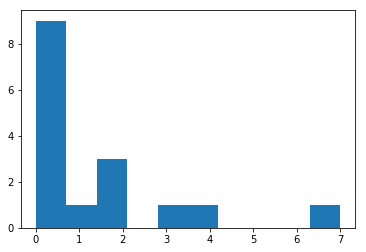

[0, 0, 0, 0, 0, 1, 7, 4, 0, 3, 0, 2, 0, 2, 0, 2]

In [14]:
# look at some network stuffs
sim = MonteCarlo()
table, Ws, Es, = sim.GDA()
table = codonTable(table)
graph = table.codonGraph
hist = nx.degree_histogram(graph)
plt.hist(hist)
plt.show()
hist

In [ ]:
# massage .csv files into the proper format
df = pd.read_csv('./res/Gilis.csv')
indices = df['Unnamed: 0'].tolist()
df.pop('Unnamed: 0')
df.index = indices
# populate dictionary representing the substitution matrix
Gilis = {}

for AA1 in indices:
    for AA2 in indices:
        Gilis[(AA1, AA2)] = df[AA1][AA2]
        
# repeat for other substituition matrix
df = pd.read_csv('./res/scv.csv')
indices = df['Unnamed: 0'].tolist()
df.pop('Unnamed: 0')
df.index = indices

SCV = {}

for AA1 in indices:
    for AA2 in indices:
        SCV[(AA1, AA2)] = df[AA1][AA2]

## References
1. Kyte, J. & Doolittle, R. F. A simple method for displaying the hydropathic character of a protein. J. Mol. Biol. 157, 105–132 (1982).
1. Novozhilov, A. S., Wolf, Y. I. & Koonin, E. V. Evolution of the genetic code: partial optimization of a random code for robustness to translation error in a rugged fitness landscape. Biol. Direct 2, 24 (2007).
1. Woese, C. R., Dugre, D. H., Saxinger, W. C. & Dugre, S. A. The Molecular Basis for the Genetic Code. Proc. Natl. Acad. Sci. 55, 966–974 (1966).